# HW3: Image Captioning

In this assignment we will be using convnets and an RNN (LSTM in this case) to take in images and return naturual language descriptions for them. We highly encourage you to complete this on Google Colab with a GPU runtime.

We will be working with Microsoft's COCO dataset, a large image dataset with acompanying text cpations for the images.

When working in colab, if your computer disconnects or is left idle, you will likely lose all progress and any files you've downloaded, so be careful of this.

**Acknowledgement:** This assignment is made possible with the help of this awesome pytorch tutorial: https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

In [1]:
# We download COCO
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/train2014.zip -P ./data/
!wget http://images.cocodataset.org/zips/val2014.zip -P ./data/

--2023-02-23 17:20:38--  http://images.cocodataset.org/annotations/annotations_trainval2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.215.81, 54.231.235.73, 52.216.34.89, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.215.81|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252872794 (241M) [application/zip]
Saving to: ‘./data/annotations_trainval2014.zip’

annotations_trainva 100%[===================>] 241.16M  32.6MB/s    in 8.0s    

2023-02-23 17:20:46 (30.3 MB/s) - ‘./data/annotations_trainval2014.zip’ saved [252872794/252872794]

--2023-02-23 17:20:46--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.66.28, 52.216.209.225, 52.217.77.60, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.66.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘

In [2]:
# and then prepare the files
!unzip ./data/annotations_trainval2014.zip -d ./data/
!rm ./data/captions_train-val2014.zip
!unzip ./data/train2014.zip -d ./data/
!rm ./data/train2014.zip 
!unzip ./data/val2014.zip -d ./data/ 
!rm ./data/val2014.zip 

Streaming output truncated to the last 5000 lines.
 extracting: ./data/val2014/COCO_val2014_000000535608.jpg  
 extracting: ./data/val2014/COCO_val2014_000000279145.jpg  
 extracting: ./data/val2014/COCO_val2014_000000243495.jpg  
 extracting: ./data/val2014/COCO_val2014_000000225791.jpg  
 extracting: ./data/val2014/COCO_val2014_000000428067.jpg  
 extracting: ./data/val2014/COCO_val2014_000000059383.jpg  
 extracting: ./data/val2014/COCO_val2014_000000558498.jpg  
 extracting: ./data/val2014/COCO_val2014_000000376123.jpg  
 extracting: ./data/val2014/COCO_val2014_000000191304.jpg  
 extracting: ./data/val2014/COCO_val2014_000000171062.jpg  
 extracting: ./data/val2014/COCO_val2014_000000014549.jpg  
 extracting: ./data/val2014/COCO_val2014_000000121152.jpg  
 extracting: ./data/val2014/COCO_val2014_000000276596.jpg  
 extracting: ./data/val2014/COCO_val2014_000000029431.jpg  
 extracting: ./data/val2014/COCO_val2014_000000036349.jpg  
 extracting: ./data/val2014/COCO_val2014_00000050

We now can create our model. 

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features


class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

Here we create the vocabulary class. This builds a vocabulary of all the captions we see during learning and allows us to quickly access them with indexes.

In [4]:
import nltk
import pickle
import argparse
from collections import Counter
from pycocotools.coco import COCO


class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def build_vocab(json, threshold):
    """Build a simple vocabulary wrapper."""
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

        if (i+1) % 1000 == 0:
            print("[{}/{}] Tokenized the captions.".format(i+1, len(ids)))

    # If the word frequency is less than 'threshold', then the word is discarded.
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    # Create a vocab wrapper and add some special tokens.
    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')

    # Add the words to the vocabulary.
    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab


Below are helper functions for COCO.

In [5]:
import torch
import torchvision.transforms as transforms
import torch.utils.data as data
import os
import pickle
import numpy as np
import nltk
from PIL import Image
from pycocotools.coco import COCO


class CocoDataset(data.Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, root, json, vocab, transform=None):
        """Set the path for images, captions and vocabulary wrapper.
        
        Args:
            root: image directory.
            json: coco annotation file path.
            vocab: vocabulary wrapper.
            transform: image transformer.
        """
        self.root = root
        self.coco = COCO(json)
        self.ids = list(self.coco.anns.keys())
        self.vocab = vocab
        self.transform = transform

    def __getitem__(self, index):
        """Returns one data pair (image and caption)."""
        coco = self.coco
        vocab = self.vocab
        ann_id = self.ids[index]
        caption = coco.anns[ann_id]['caption']
        img_id = coco.anns[ann_id]['image_id']
        path = coco.loadImgs(img_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocab('<start>'))
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        target = torch.Tensor(caption)
        return image, target

    def __len__(self):
        return len(self.ids)


def collate_fn(data):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 256, 256).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    # Merge images (from tuple of 3D tensor to 4D tensor).
    images = torch.stack(images, 0)

    # Merge captions (from tuple of 1D tensor to 2D tensor).
    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

def get_loader(root, json, vocab, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom coco dataset."""
    # COCO caption dataset
    coco = CocoDataset(root=root,
                       json=json,
                       vocab=vocab,
                       transform=transform)
    
    # Data loader for COCO dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    data_loader = torch.utils.data.DataLoader(dataset=coco, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_fn)
    return data_loader

Some helper functions for our images.

In [6]:
import argparse
import os
from PIL import Image


def resize_image(image, size):
    """Resize an image to the given size."""
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    """Resize the images in 'image_dir' and save into 'output_dir'."""
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                img = resize_image(img, size)
                img.save(os.path.join(output_dir, image), img.format)
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))


We will create our vocabulary using nltk's punkt, a popular sentence tokenizer.

In [7]:
nltk.download('punkt')
import os
print(os.getcwd())
caption_path = 'data/annotations/captions_train2014.json'
vocab_path = "data/vocab.pk1"
threshold = 4
vocab = build_vocab(caption_path, threshold)
with open(vocab_path, 'wb') as f:
  pickle.dump(vocab, f)

print(f"Total vocabulary size: {len(vocab)}")
print(f"Saved the vocabulary wrapper to {vocab_path}")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/content
loading annotations into memory...
Done (t=0.89s)
creating index...
index created!
[1000/414113] Tokenized the captions.
[2000/414113] Tokenized the captions.
[3000/414113] Tokenized the captions.
[4000/414113] Tokenized the captions.
[5000/414113] Tokenized the captions.
[6000/414113] Tokenized the captions.
[7000/414113] Tokenized the captions.
[8000/414113] Tokenized the captions.
[9000/414113] Tokenized the captions.
[10000/414113] Tokenized the captions.
[11000/414113] Tokenized the captions.
[12000/414113] Tokenized the captions.
[13000/414113] Tokenized the captions.
[14000/414113] Tokenized the captions.
[15000/414113] Tokenized the captions.
[16000/414113] Tokenized the captions.
[17000/414113] Tokenized the captions.
[18000/414113] Tokenized the captions.
[19000/414113] Tokenized the captions.
[20000/414113] Tokenized the captions.
[21000/414113] Tokenized the captions.
[22000/414113] Tokenized the captions.
[23000/414113] Tokenized the captions.
[24000/414113] Token

In [8]:
image_dir = "data/train2014/"
output_dir = "data/resized2014/"
image_size = 128

image_dir = image_dir
output_dir = output_dir
image_size = [image_size, image_size]
resize_images(image_dir, output_dir, image_size)

[100/82783] Resized the images and saved into 'data/resized2014/'.
[200/82783] Resized the images and saved into 'data/resized2014/'.
[300/82783] Resized the images and saved into 'data/resized2014/'.
[400/82783] Resized the images and saved into 'data/resized2014/'.
[500/82783] Resized the images and saved into 'data/resized2014/'.
[600/82783] Resized the images and saved into 'data/resized2014/'.
[700/82783] Resized the images and saved into 'data/resized2014/'.
[800/82783] Resized the images and saved into 'data/resized2014/'.
[900/82783] Resized the images and saved into 'data/resized2014/'.
[1000/82783] Resized the images and saved into 'data/resized2014/'.
[1100/82783] Resized the images and saved into 'data/resized2014/'.
[1200/82783] Resized the images and saved into 'data/resized2014/'.
[1300/82783] Resized the images and saved into 'data/resized2014/'.
[1400/82783] Resized the images and saved into 'data/resized2014/'.
[1500/82783] Resized the images and saved into 'data/resi

We will set some parameters below for our images, paths, and training. 

Note that if you lose connection to Colab during execution, you will lose all progress/uploaded files. Because of this we will only be training for 1 epoch. If you would like to better train the network, we encourage you to train longer (try 5 epochs). Note this is optional.

In [22]:
model_path = "models/"
crop_size = 100
vocab_path = "data/vocab.pk1"
image_dir = "data/resized2014"
caption_path = "data/annotations/captions_train2014.json"
log_step = 10
save_step = 3000
embed_size = 256
hidden_size = 512
num_layers = 1

num_epochs = 5
batch_size = 128
num_workers=1
learning_rate = 0.001

In [23]:
## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

Let's now create our training loop. We will first must add transforms to our images and create a dataloader.

We then initialize our models, the encoder and decober and setup loss and optimizer.

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists(model_path):
        os.makedirs(model_path)

# Add a random crop size crop_size and
# random horizontal flip (default parameters) to the below transform
transform = transforms.Compose([ 
  ### START CODE
    transforms.RandomCrop(crop_size),
    transforms.RandomHorizontalFlip(),
  ### END CODE
  transforms.ToTensor(), 
  transforms.Normalize((0.485, 0.456, 0.406), 
                      (0.229, 0.224, 0.225))])

with open(vocab_path, 'rb') as f:
  vocab = pickle.load(f)

# Create your data loader using the get_loader function. 
### START CODE
data_loader = get_loader(image_dir, caption_path, vocab, transform, batch_size, shuffle=True, num_workers=num_workers)
### END CODE

encoder = EncoderCNN(embed_size).to(device).eval() 
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)

criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

total_step = len(data_loader)
for epoch in range(num_epochs):
  for i, (images, captions, lengths) in enumerate(data_loader):

    images = images.to(device)
    captions = captions.to(device)
    targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

    features = encoder(images)
    outputs = decoder(features, captions, lengths)
    loss = criterion(outputs, targets)
    decoder.zero_grad()
    encoder.zero_grad()
    loss.backward()
    optimizer.step()

    if i % log_step == 0:
      print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Perplexity: {:5.4f}'
        .format(epoch, num_epochs, i, total_step, loss.item(), np.exp(loss.item())))
      
    # Save the model checkpoints
    if (i+1) % save_step == 0:
      torch.save(decoder.state_dict(), os.path.join(
          model_path, 'decoder-{}-{}.ckpt'.format(epoch+1, i+1)))
      torch.save(encoder.state_dict(), os.path.join(
          model_path, 'encoder-{}-{}.ckpt'.format(epoch+1, i+1)))


loading annotations into memory...
Done (t=1.09s)
creating index...
index created!
Epoch [0/5], Step [0/3236], Loss: 9.2077, Perplexity: 9973.7811
Epoch [0/5], Step [10/3236], Loss: 5.2028, Perplexity: 181.7859
Epoch [0/5], Step [20/3236], Loss: 4.9288, Perplexity: 138.2158
Epoch [0/5], Step [30/3236], Loss: 4.6931, Perplexity: 109.1956
Epoch [0/5], Step [40/3236], Loss: 4.4373, Perplexity: 84.5501
Epoch [0/5], Step [50/3236], Loss: 4.3225, Perplexity: 75.3752
Epoch [0/5], Step [60/3236], Loss: 4.0922, Perplexity: 59.8698
Epoch [0/5], Step [70/3236], Loss: 4.1593, Perplexity: 64.0256
Epoch [0/5], Step [80/3236], Loss: 3.9500, Perplexity: 51.9344
Epoch [0/5], Step [90/3236], Loss: 3.7581, Perplexity: 42.8669
Epoch [0/5], Step [100/3236], Loss: 3.8437, Perplexity: 46.6961
Epoch [0/5], Step [110/3236], Loss: 3.7817, Perplexity: 43.8903
Epoch [0/5], Step [120/3236], Loss: 3.6942, Perplexity: 40.2139
Epoch [0/5], Step [130/3236], Loss: 3.6997, Perplexity: 40.4364
Epoch [0/5], Step [140/3236

In [25]:
def load_image(image_path, size=100, transform=None):
    image = Image.open(image_path).convert('RGB')
    image = image.resize([size, size], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

Lets pull some images to test the network with. Feel free to try additional images!

In [26]:
!wget http://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg -O image1.jpg
!wget http://farm1.staticflickr.com/110/304953668_629cb610c1_z.jpg -O image2.jpg
!wget http://farm2.staticflickr.com/1103/567229075_2cf8456f01_q.jpg -O image3.jpg

--2023-02-23 19:36:14--  http://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg
Resolving farm6.staticflickr.com (farm6.staticflickr.com)... 65.9.83.84, 2600:9000:2104:9600:0:5a51:64c9:c681, 2600:9000:2104:6200:0:5a51:64c9:c681, ...
Connecting to farm6.staticflickr.com (farm6.staticflickr.com)|65.9.83.84|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg [following]
--2023-02-23 19:36:14--  https://farm6.staticflickr.com/5540/9036468623_61a0344eab_z.jpg
Connecting to farm6.staticflickr.com (farm6.staticflickr.com)|65.9.83.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image1.jpg’

image1.jpg              [ <=>                ] 107.82K  --.-KB/s    in 0.007s  

2023-02-23 19:36:14 (15.0 MB/s) - ‘image1.jpg’ saved [110406]

--2023-02-23 19:36:14--  http://farm1.staticflickr.com/110/304953668_629cb610c1_z.jpg
Reso

<start> a bus that is sitting in the street .


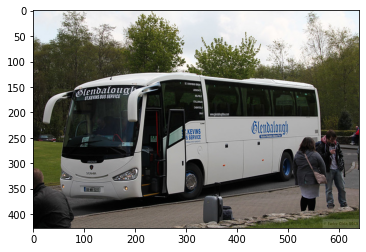

In [27]:
import matplotlib.pyplot as plt
from PIL import Image

transform = transforms.Compose([ transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])
image = load_image("image1.jpg", 100, transform)

# Generate an caption from the image
feature = encoder(image.to(device))
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
  sentence = ' '.join(sampled_caption)
    
# Print out the image and the generated caption
print (sentence)
image1 = Image.open("image1.jpg")
plt.imshow(np.asarray(image1))

Try and send `image2` and `image3` through the network and see what the resulting captions are.

<start> a man in a wheelchair is holding a tennis racket .


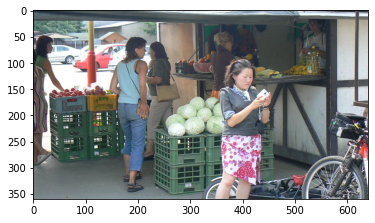

In [28]:
image2 = load_image("image2.jpg", 100, transform)
### START CODE
# Generate an caption from the image
feature = encoder(image2.to(device))
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
  sentence2 = ' '.join(sampled_caption)
### END CODE
# Print out the image and the generated caption
print (sentence2)
image = Image.open("image2.jpg")
plt.imshow(np.asarray(image))

<start> a white toilet with a blue seat and a blue towel on the ground .


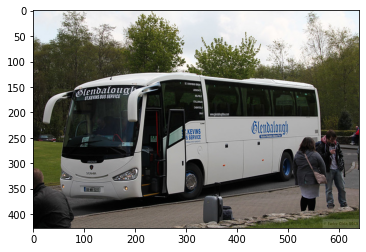

In [29]:
image3 = load_image("image3.jpg", 100, transform)
### START CODE
# Generate an caption from the image
feature = encoder(image3.to(device))
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()

# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
  sentence3 = ' '.join(sampled_caption)
### END CODE
print (sentence3)
image = Image.open("image1.jpg")
plt.imshow(np.asarray(image))

If you chose not to fully train the network and left the epochs to its default, the network may not be giving very satisfying captions.

Let's load in a pretrained network and see its results.

In [30]:
# Download the weights and vocab.
!wget https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
!wget https://www.dropbox.com/s/26adb7y9m98uisa/vocap.zip?dl=0
!mv vocap.zip?dl=0 vocap.zip
!mv pretrained_model.zip?dl=0 pretrained_model.zip

--2023-02-23 19:36:16--  https://www.dropbox.com/s/ne0ixz5d58ccbbz/pretrained_model.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/ne0ixz5d58ccbbz/pretrained_model.zip [following]
--2023-02-23 19:36:16--  https://www.dropbox.com/s/raw/ne0ixz5d58ccbbz/pretrained_model.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc9d9e00d13246ec90ffaf878a37.dl.dropboxusercontent.com/cd/0/inline/B3DiJCPBT3x7tjLFHdzA7hWFvNho9n7snItW7mqw2Q4y6llHr48pR7BdSI49gXN7H9UsO044WUSasoi5TZkoAoLUbk1aZk_gfBEG1GrTt8ToNsG6A59zWDv2hcB0rMtTuE51SCEH5Yc5Y6xbYAN92GX-d1gu4a3BSkvhI-YQBBjOVw/file# [following]
--2023-02-23 19:36:17--  https://uc9d9e00d13246ec90ffaf878a37.dl.dropboxusercontent.com/cd/0/inline/B3DiJCPBT3x7tjLFHdzA7hWFvNho9n7snItW7mqw2Q4y6llH

In [31]:
!unzip -q /content/pretrained_model.zip -d models 
!unzip -q /content/vocap.zip -d models
!pip install torchtext

replace models/encoder-5-3000.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace models/decoder-5-3000.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace models/vocab.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<start> a bus that is parked in a parking lot . <end>


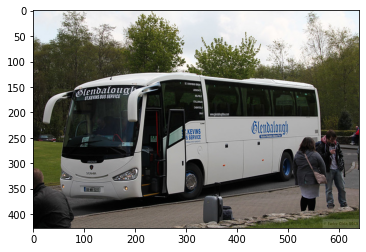

In [32]:
vocab = pickle.load(open("/content/models/vocab.pkl","rb"))

# Create an encoder with embed size 256, and set to eval
# name is encoder_pretrained
### START CODE
encoder_pretrained = EncoderCNN(256).eval()
### END CODE

decoder_pretrained = DecoderRNN(embed_size=256, hidden_size=512, vocab_size= len(vocab), num_layers=1).to(device)
encoder = encoder_pretrained.to(device)
decoder_pretrained = decoder_pretrained.to(device)
    
# Load the pre-trained weights we downloaded for 
# the encoder and decoder
### START CODE
encoder.load_state_dict(torch.load('models/encoder-5-3000.pkl'))
decoder_pretrained.load_state_dict(torch.load('models/decoder-5-3000.pkl'))
### END CODE

transform = transforms.Compose([ transforms.ToTensor(),  transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

# Prepare an image
image = Image.open("image1.jpg").convert('RGB')
image = image.resize([224, 224], Image.LANCZOS)
image = transform(image).unsqueeze(0)
image_tensor = image.to(device)
    
# Generate an caption from the image
feature = encoder_pretrained(image_tensor)
sampled_ids = decoder_pretrained.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()
    
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
sentence = ' '.join(sampled_caption)
    
# Print out the image and the generated caption
print (sentence)
image = Image.open("image1.jpg")
import matplotlib.pyplot as plt

plt.imshow(np.asarray(image))

Send the remaining images, image2 and image3 to the network and get the predicted captions.

<start> a group of people standing around a table with a bunch of bananas . <end>


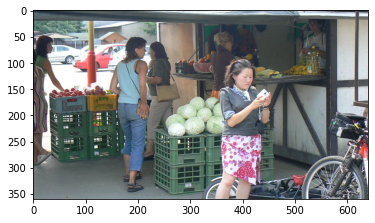

In [33]:
image2 = Image.open("image2.jpg").convert('RGB')
### START CODE
image2 = image2.resize([224, 224], Image.LANCZOS)
image2 = transform(image2).unsqueeze(0)
image_tensor2 = image2.to(device)
    
# Generate an caption from the image
feature2 = encoder_pretrained(image_tensor2)
sampled_ids2 = decoder_pretrained.sample(feature2)
sampled_ids2 = sampled_ids2[0].cpu().numpy()
    
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids2:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
sentence = ' '.join(sampled_caption)
    
# Print out the image and the generated caption
print (sentence)
image2 = Image.open("image2.jpg")
import matplotlib.pyplot as plt

plt.imshow(np.asarray(image2))
### END CODE

<start> a cat sitting on a chair next to a cat . <end>


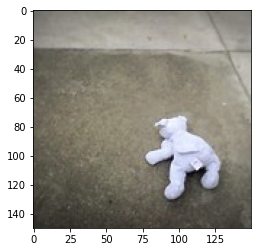

In [34]:
image3 = Image.open("image3.jpg").convert('RGB')
### START CODE
image3 = image3.resize([224, 224], Image.LANCZOS)
image3 = transform(image3).unsqueeze(0)
image_tensor3 = image3.to(device)
    
# Generate an caption from the image
feature3 = encoder_pretrained(image_tensor3)
sampled_ids3 = decoder_pretrained.sample(feature3)
sampled_ids3 = sampled_ids3[0].cpu().numpy()
    
# Convert word_ids to words
sampled_caption = []
for word_id in sampled_ids3:
  word = vocab.idx2word[word_id]
  sampled_caption.append(word)
  if word == '<end>':
    break
sentence = ' '.join(sampled_caption)
    
# Print out the image and the generated caption
print (sentence)
image3 = Image.open("image3.jpg")
import matplotlib.pyplot as plt

plt.imshow(np.asarray(image3))
### END CODE